# Under and over fitting
> Validation and learning curves
- toc: true
- badges: false
- comments: true
- author: Cécile Gallioz
- categories: [sklearn]

# Preparation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [2]:
from sklearn.datasets import fetch_california_housing
myDataFrame = fetch_california_housing(as_frame=True)

In [3]:
data, target = myDataFrame.data, myDataFrame.target
target *= 100  # rescale the target in k$

In [4]:
print(f"The dataset data contains {data.shape[0]} samples and {data.shape[1]} features")

The dataset data contains 20640 samples and 8 features


In [5]:
data.dtypes

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

# Overfitting vs. underfitting

In [6]:
regressor = DecisionTreeRegressor()

In [7]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)

In [8]:
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)

In [9]:
scores = cv_results["test_score"]
fit_time = cv_results["fit_time"]
print("The accuracy is "
      f"{scores.mean():.3f} +/- {scores.std():.3f}, for {fit_time.mean():.3f} seconds")

The accuracy is -46.088 +/- 0.886, for 0.135 seconds


In [10]:
cv_results = pd.DataFrame(cv_results)

In [11]:
scores = pd.DataFrame()

In [12]:
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

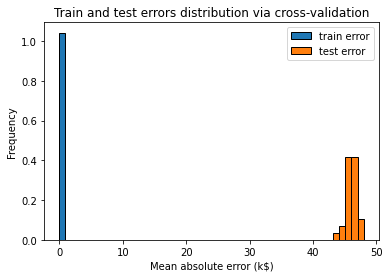

In [13]:
scores.plot.hist(bins=50, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Here, we observe a **small training error** (actually zero), meaning that
the model is **not under-fitting**: it is flexible enough to capture any
variations present in the training set.

However the **significantly larger testing error** tells us that the
model is **over-fitting**: the model has memorized many variations of the
training set that could be considered "noisy" because they do not generalize
to help us make good prediction on the test set.

In [15]:
%%time
max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

Wall time: 8.67 s


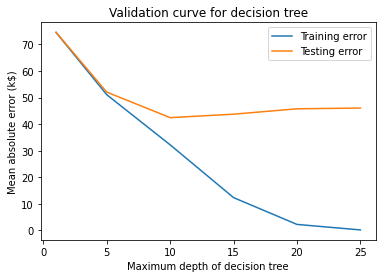

In [16]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

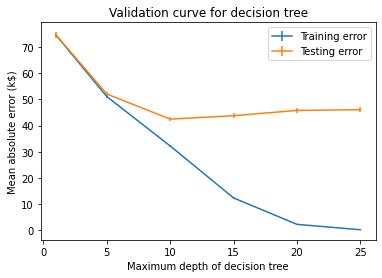

In [17]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

# Learning curve
Let's compute the learning curve for a decision tree and vary the
proportion of the training set from 10% to 100%.

In [20]:
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [21]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)

In [23]:
results = learning_curve(
    regressor, data, target, train_sizes=train_sizes, cv=cv,
    scoring="neg_mean_absolute_error", n_jobs=2)
train_size, train_scores, test_scores = results[:3]
# Convert the scores into errors
train_errors, test_errors = -train_scores, -test_scores

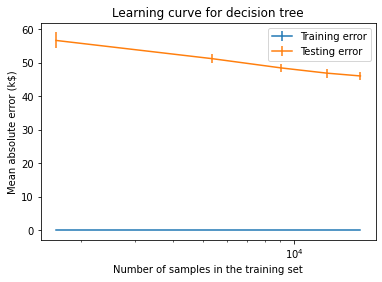

In [24]:
plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training error")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Testing error")
plt.legend()

plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Learning curve for decision tree")

Looking at the training error alone, we see that we get an error of 0 k$. It
means that the trained model (i.e. decision tree) is clearly overfitting the
training data.

Looking at the testing error alone, we observe that the more samples are
added into the training set, the lower the testing error becomes. Also, we
are searching for the plateau of the testing error for which there is no
benefit to adding samples anymore or assessing the potential gain of adding
more samples into the training set.

If we achieve a plateau and adding new samples in the training set does not
reduce the testing error, we might have reach the Bayes error rate using the
available model. Using a more complex model might be the only possibility to
reduce the testing error further.